In [1]:
# OPERATIONAL PACKAGES ---------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import inf
import scipy as sp
from scipy.optimize import curve_fit

# STYLE RESOURCES ---------------------------------------
plt.style.reload_library()
plt.style.use(['science', 'grid'])

# FITTING PACKAGES ---------------------------------------
from lmfit import Model, Parameters
import scipy.optimize as optimization
from IPython.display import display, Markdown

In [105]:
# DEFINING A FUNCTION THAT RETURNS THE UNCERTAINTY USING VARIATIONAL METHOD ---------------------------------------
def uncertainty_var(values, deltas, function):
    values, deltas = np.array(values), np.array(deltas)
    delta_matrix = deltas*np.identity(values.shape[0])
    sum = 0
    for delta in delta_matrix:
        sum += (0.5*(abs(function(values + delta) - function(values)) + abs(function(values-delta) - function(values))))**2
    return np.sqrt(sum)

# FUNCTION FOR PLOTTING A SCATTER PLOT ---------------------------------------
def ScatterPlot(xdata,ydata,error_x,error_y,color,x_label,y_label):
    
    # SCATTER PLOT
    fig = plt.figure(figsize=(5, 5), dpi=80)
    plt.errorbar(xdata,ydata,yerr=error_y,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    plt.errorbar(xdata,ydata,xerr=error_x,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("Figures/figure1.png")
    

Gaussian = lambda x,a,b,c : a*np.exp((-(x-b)**2)/(2*c**2))
Gauss_derivative = lambda x,a,b,c : ((b-x)/c**2)*Gaussian(x,a,b,c)*0.1
Gauss_derivative_param = lambda params : Gauss_derivative(params[0],params[1],params[2],params[3])
gradient = lambda params : np.gradient(params[0])
Bremsstrahlung = lambda x, a, b : (a/x**2)*(x/b-1)
Bremsstrahlung2 = lambda x, a, b : (a/b)*(np.log(x/b) + b/x - 1)
linear = lambda x, a, b : a*x + b

from scipy.constants import h, c, e

def FUNCTION_FIT(xdata, ydata, error_x, error_y, color, x_label, y_label, function):
    
    # Plotting scatter plot first
    ScatterPlot(xdata,ydata,error_x,error_y,color,x_label,y_label)
    
    # Finding best fit value
    optimal = optimization.curve_fit(function, xdata, ydata, np.array([h*c/e	,0.035424056695200073]), error_y)
    #optimal = optimization.curve_fit(function, xdata, ydata, np.array([5200,22.486891325246766,1,5400,22.545695655325417,1]), error_y)
    a, b = optimal[0][0], optimal[0][1]
    #d, e, f = optimal[0][3], optimal[0][4], optimal[0][5]
    pars, cov = curve_fit(f=function, xdata=xdata, ydata=ydata, p0=[a, b], bounds=(-np.inf, np.inf))
    #pars, cov = curve_fit(f=function, xdata=xdata, ydata=ydata, p0=[a, b, c, d, e, f], bounds=(-np.inf, np.inf))
    stdevs = np.sqrt(np.diag(cov))
    chi_squared = np.sum((function(xdata, *pars) - ydata)**2/error_y**2)
    red_chi_squared = chi_squared/(np.size(ydata)-np.size(pars))
    p_value = 1.000-sp.stats.chi2.cdf(chi_squared,(np.size(ydata)-np.size(pars)))
    variables = ['a', 'b']
    #variables = ['a', 'b', 'c', 'd', 'e', 'f']
    display(Markdown('## Fit Statistics'))
    df2 = pd.DataFrame()
    df2["Dof"] = [np.size(ydata)-np.size(pars)]
    df2["p-value"] = [p_value]
    df2["$\chi^2$"] = [chi_squared]
    df2["$\overline{\chi}^2$"] = [red_chi_squared]
    display(df2)
    
    display(Markdown('## Variables'))
    df = pd.DataFrame()
    df["Name"] = variables
    df["Value"] = pars
    df["Std"] = stdevs
    display(df)
     
    # Plotting Fitted Function
    a, b = pars[0], pars[1]
    #d, e, f = pars[3], pars[4], pars[5]
    da, db = stdevs[0], stdevs[1]
    #dd, de, df = stdevs[3], stdevs[4], stdevs[5]
    x = np.arange(xdata.min(), xdata.max(), (xdata.max()-xdata.min())/1000) 
    y = function(x,a,b)
    print('Intensity =', y.max())
    #y = function(x,a,b,c,d,e,f)
    xmax = x[np.where(y == y.max())[0][0]]
    label = r'$\theta = \ $' + str("{:.2f}".format(xmax)) + '$^\circ$'
    plt.plot(x, function(x, a, b), color=color)
    #plt.plot(x, function(x, a, b, c, d, e, f), color=color)
    #plt.axvline(x=xmax, color='k', linestyle='--', label=label)
    
    #VERTICAL LINE 
    #plt.legend(prop={'size': 12}, loc=1)
    
    plt.savefig("Figures/figure.png")
    plt.show()
    
    return [variables, pars, stdevs]

# DEFINING A FUNCTION THAT RETURNS THE WEIGHTED AVERAGE WITH UNCERTAINTY
def weighted_avgs(values, deltas):
    weights = np.array(list(map(lambda x : 1/x**2, deltas)))
    best_val = np.dot(np.array(values), weights)/weights.sum()
    uncert = 1/np.sqrt(weights.sum())
    return [best_val, uncert]

# DEFINING A FUNCTION THAT RETURNS COUNTING ERROR
count_error = lambda val : np.sqrt(val)

-----
### 35 kV WITH FILTER
-----

In [82]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1qogTfmCQXAS6o2U-FCVnL6LUQsT4V-npiPWFMsUuwH8'
workSheetName = '35kV-withFilter'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(googleSheetId, workSheetName)
df = pd.read_csv(URL)
df['Imp_error'] = df.apply(lambda x: count_error(x['Imp/s']), axis=1)
df['Gradient'] = np.gradient(df['Imp_error'])
df

,Theta,Imp/s,Imp_error,Gradient
0,3.5,56,7.483315,-1.002574
1,3.6,42,6.480741,-0.913230
2,3.7,32,5.656854,0.038349
3,3.8,43,6.557439,0.562738
4,3.9,46,6.782330,-0.363243
...,...,...,...,...
211,24.6,70,8.366600,0.250122
212,24.7,68,8.246211,-0.342727
213,24.8,59,7.681146,-0.186102
214,24.9,62,7.874008,0.221446


## Fit Statistics

,Dof,p-value,$\chi^2$,$\overline{\chi}^2$
0,10,0.0,2794.293098,279.42931


## Variables

,Name,Value,Std
0,a,5981.229709,258.032336
1,b,22.570919,0.007303
2,c,-0.146612,0.007303


Intensity = 5981.2186924759535


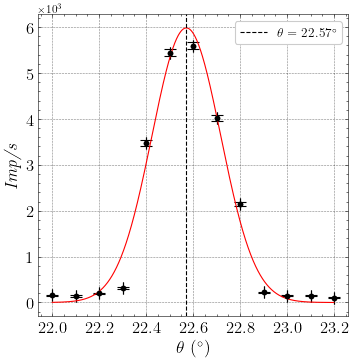

In [83]:
# PLOTTING OUR DATA ---------------------------------------
minVal, maxVal = 22, 23.2
df_filtered = df[(df['Theta'] >= minVal) & (df['Theta'] <= maxVal)]
xdata, ydata, error_x, error_y = df_filtered['Theta'], df_filtered['Imp/s'], 0, df_filtered['Imp_error']
results = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', r'$\theta \ (^\circ)$', 'Imp/s', Gaussian)

## Fit Statistics

,Dof,p-value,$\chi^2$,$\overline{\chi}^2$
0,8,0.0,134.858727,16.857341


## Variables

,Name,Value,Std
0,a,232.908669,23.717636
1,b,20.298572,0.025524
2,c,-0.217413,0.025852


Intensity = 232.90821674096185


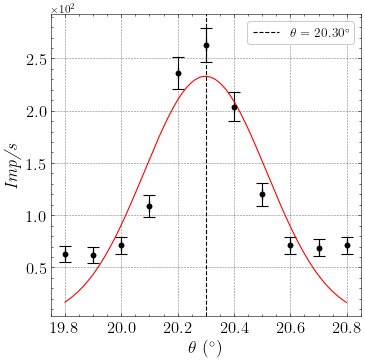

In [84]:
# PLOTTING OUR DATA ---------------------------------------
a, b, c = results[1][0], results[1][1], results[1][2]
da, db, dc = results[2][0], results[2][1], results[2][2]
minVal, maxVal = 19.8, 20.8
df_filtered = df[(df['Theta'] >= minVal) & (df['Theta'] <= maxVal)]
xdata, ydata, error_x, error_y = df_filtered['Theta'], df_filtered['Imp/s'], 0, df_filtered['Imp_error']
results = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', r'$\theta \ (^\circ)$', 'Imp/s', Gaussian)

In [85]:
5981.2186924759535/232.90821674096185

25.680582575273437

-----
### 35 kV WITH NO FILTER
-----

In [89]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1qogTfmCQXAS6o2U-FCVnL6LUQsT4V-npiPWFMsUuwH8'
workSheetName = '35kV-NoFilter'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(googleSheetId, workSheetName)
df = pd.read_csv(URL)
df['Imp_error'] = df.apply(lambda x: count_error(x['Imp/s']), axis=1)
df['Gradient'] = np.gradient(df['Imp_error'])
df

,Theta,Imp/s,Imp_error,Gradient
0,3.5,64,8.000000,-1.519259
1,3.6,42,6.480741,-0.429286
2,3.7,51,7.141428,-0.842455
3,3.8,23,4.795832,-1.021204
4,3.9,26,5.099020,-0.106628
...,...,...,...,...
211,24.6,118,10.862780,-0.092061
212,24.7,116,10.770330,-0.332371
213,24.8,104,10.198039,0.092061
214,24.9,120,10.954451,0.262883


## Fit Statistics

,Dof,p-value,$\chi^2$,$\overline{\chi}^2$
0,10,0.0,3473.204951,347.320495


## Variables

,Name,Value,Std
0,a,8875.360715,393.018347
1,b,22.597946,0.007428
2,c,0.145266,0.007428


Intensity = 8875.335515193194


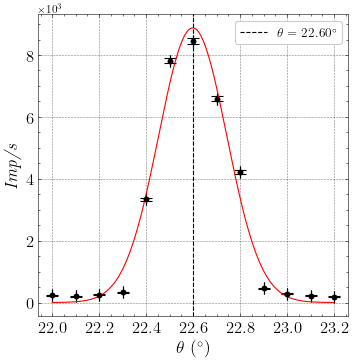

In [91]:
# PLOTTING OUR DATA ---------------------------------------
minVal, maxVal = 22, 23.2
df_filtered = df[(df['Theta'] >= minVal) & (df['Theta'] <= maxVal)]
xdata, ydata, error_x, error_y = df_filtered['Theta'], df_filtered['Imp/s'], 0, df_filtered['Imp_error']
results = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', r'$\theta \ (^\circ)$', 'Imp/s', Gaussian)

## Fit Statistics

,Dof,p-value,$\chi^2$,$\overline{\chi}^2$
0,8,0.0,894.859347,111.857418


## Variables

,Name,Value,Std
0,a,2857.757445,148.797756
1,b,20.334558,0.008701
2,c,0.144719,0.008701


Intensity = 2857.7441265418647


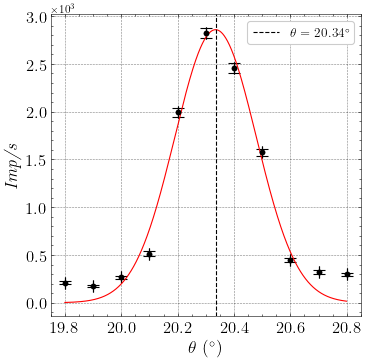

In [92]:
# PLOTTING OUR DATA ---------------------------------------
minVal, maxVal = 19.8, 20.8
df_filtered = df[(df['Theta'] >= minVal) & (df['Theta'] <= maxVal)]
xdata, ydata, error_x, error_y = df_filtered['Theta'], df_filtered['Imp/s'], 0, df_filtered['Imp_error']
results = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', r'$\theta \ (^\circ)$', 'Imp/s', Gaussian)

In [93]:
8875.335515193194/2857.7441265418647

3.1057138505724695

<ipython-input-65-323a64061686>:4: RuntimeWarning: invalid value encountered in multiply
  delta_matrix = deltas*np.identity(values.shape[0])
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

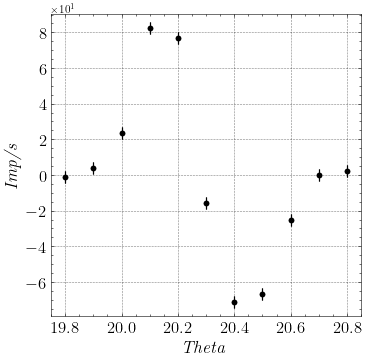

In [71]:
# PLOTTING OUR DATA ---------------------------------------
df['GradientError'] = df.apply(lambda x: uncertainty_var([x['Theta'],a,b,c], [0,da,db,dc], Gauss_derivative_param), axis=1)
minVal, maxVal = 19.8, 20.8
df_filtered = df[(df['Theta'] >= minVal) & (df['Theta'] <= maxVal)]
xdata, ydata, error_x, error_y = df_filtered['Theta'], np.gradient(df_filtered['Imp/s']), 0, df_filtered['GradientError']
results = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', 'Theta', 'Imp/s', Gaussian)

-----
### 35kV
-----

In [70]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1qogTfmCQXAS6o2U-FCVnL6LUQsT4V-npiPWFMsUuwH8'
workSheetName = '35kV-withFilter'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(googleSheetId, workSheetName)
df = pd.read_csv(URL)
df['Imp_error'] = df.apply(lambda x: count_error(x['Imp/s']), axis=1)
df['Gradient'] = np.gradient(df['Imp_error'])
df['lambda'] = 2*2.014*0.1*np.sin(df['Theta']*np.pi/180) # nm

## Fit Statistics

,Dof,p-value,$\chi^2$,$\overline{\chi}^2$
0,39,0.000011,88.333701,2.264967


## Variables

,Name,Value,Std
0,a,2.675577,0.059992
1,b,0.033287,0.000214


Intensity = 601.7161573896966


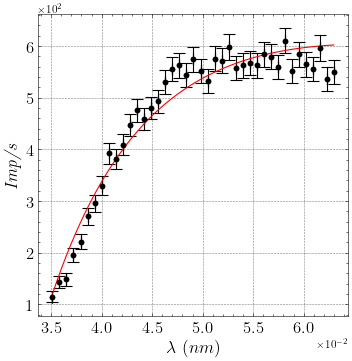

In [72]:
# PLOTTING OUR DATA ---------------------------------------
minVal, maxVal = 5, 9
df_filtered = df[(df['Theta'] >= minVal) & (df['Theta'] <= maxVal)]
xdata, ydata, error_x, error_y = df_filtered['lambda'], df_filtered['Imp/s'], 0, df_filtered['Imp_error']
results = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', r'$\lambda \ (nm)$', 'Imp/s', Bremsstrahlung)

-----
### 30kV
-----

In [124]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1qogTfmCQXAS6o2U-FCVnL6LUQsT4V-npiPWFMsUuwH8'
workSheetName = '30kV'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(googleSheetId, workSheetName)
df = pd.read_csv(URL)
df['Imp_error'] = df.apply(lambda x: count_error(x['Imp/s']), axis=1)
df['Gradient'] = np.gradient(df['Imp_error'])
df['lambda'] = 2*2.014*0.1*np.sin(df['Theta']*np.pi/180) # nm

## Fit Statistics

,Dof,p-value,$\chi^2$,$\overline{\chi}^2$
0,44,0.0,205.829436,4.677942


## Variables

,Name,Value,Std
0,a,2.495206,0.052339
1,b,0.038930,0.000207


Intensity = 406.28291633633984


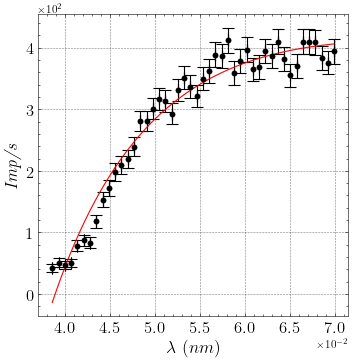

In [130]:
# PLOTTING OUR DATA ---------------------------------------
minVal, maxVal = 5.5, 10
df_filtered = df[(df['Theta'] >= minVal) & (df['Theta'] <= maxVal)]
xdata, ydata, error_x, error_y = df_filtered['lambda'], df_filtered['Imp/s'], 0, df_filtered['Imp_error']
results = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', r'$\lambda \ (nm)$', 'Imp/s', Bremsstrahlung)

-----
### 25kV
-----

In [46]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1qogTfmCQXAS6o2U-FCVnL6LUQsT4V-npiPWFMsUuwH8'
workSheetName = '25kV'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(googleSheetId, workSheetName)
df = pd.read_csv(URL)
df['Imp_error'] = df.apply(lambda x: count_error(x['Imp/s']), axis=1)
df['Gradient'] = np.gradient(df['Imp_error'])
df['lambda'] = 2*2.014*0.1*np.sin(df['Theta']*np.pi/180) # nm

## Fit Statistics

,Dof,p-value,$\chi^2$,$\overline{\chi}^2$
0,36,2.122746e-13,135.174644,3.754851


## Variables

,Name,Value,Std
0,a,2.716668,0.080091
1,b,0.048141,0.000278


Intensity = 264.5048035670367


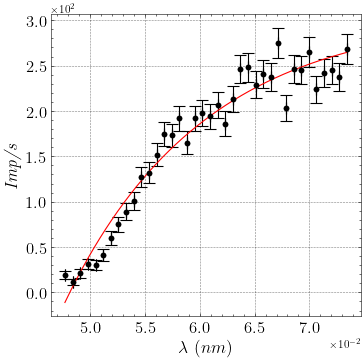

In [54]:
# PLOTTING OUR DATA ---------------------------------------
minVal, maxVal = 6.8, 10.5
df_filtered = df[(df['Theta'] >= minVal) & (df['Theta'] <= maxVal)]
xdata, ydata, error_x, error_y = df_filtered['lambda'], df_filtered['Imp/s'], 0, df_filtered['Imp_error']
results = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', r'$\lambda \ (nm)$', 'Imp/s', Bremsstrahlung)

-----
### 20kV
-----

In [74]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1qogTfmCQXAS6o2U-FCVnL6LUQsT4V-npiPWFMsUuwH8'
workSheetName = '20kV'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(googleSheetId, workSheetName)
df = pd.read_csv(URL)
df['Imp_error'] = df.apply(lambda x: count_error(x['Imp/s']), axis=1)
df['Gradient'] = np.gradient(df['Imp_error'])
df['lambda'] = 2*2.014*0.1*np.sin(df['Theta']*np.pi/180) # nm

## Fit Statistics

,Dof,p-value,$\chi^2$,$\overline{\chi}^2$
0,19,0.000353,47.038784,2.475725


## Variables

,Name,Value,Std
0,a,2.917289,0.156172
1,b,0.061520,0.000405


Intensity = 123.05787663085614


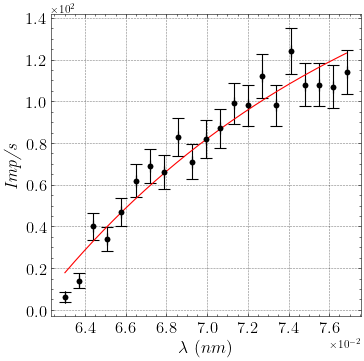

In [76]:
# PLOTTING OUR DATA ---------------------------------------
minVal, maxVal = 9, 11
df_filtered = df[(df['Theta'] >= minVal) & (df['Theta'] <= maxVal)]
xdata, ydata, error_x, error_y = df_filtered['lambda'], df_filtered['Imp/s'], 0, df_filtered['Imp_error']
results = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', r'$\lambda \ (nm)$', 'Imp/s', Bremsstrahlung)

-----
### 15kV
-----

In [87]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1qogTfmCQXAS6o2U-FCVnL6LUQsT4V-npiPWFMsUuwH8'
workSheetName = '15kV'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(googleSheetId, workSheetName)
df = pd.read_csv(URL)
df['Imp_error'] = df.apply(lambda x: count_error(x['Imp/s']), axis=1)
df['Gradient'] = np.gradient(df['Imp_error'])
df['lambda'] = 2*2.014*0.1*np.sin(df['Theta']*np.pi/180) # nm

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:755: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


## Fit Statistics

,Dof,p-value,$\chi^2$,$\overline{\chi}^2$
0,29,0.0,inf,inf


## Variables

,Name,Value,Std
0,a,0.742771,0.160496
1,b,0.075469,0.003169


Intensity = 26.056068195851406


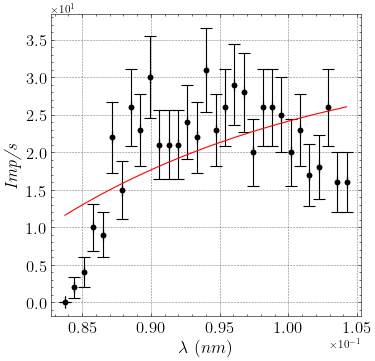

In [96]:
# PLOTTING OUR DATA ---------------------------------------
minVal, maxVal = 12, 15
df_filtered = df[(df['Theta'] >= minVal) & (df['Theta'] <= maxVal)]
xdata, ydata, error_x, error_y = df_filtered['lambda'], df_filtered['Imp/s'], 0, df_filtered['Imp_error']
results = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', r'$\lambda \ (nm)$', 'Imp/s', Bremsstrahlung)

In [131]:
V = np.array([1/35e3, 1/30e3, 1/25e3, 1/20e3])	
lambda_min = np.array([0.033287, 0.038743, 0.048141, 0.061520])
delta_lambda = np.array([0.000214, 0.000233, 0.000278, 0.000405])

## Fit Statistics

,Dof,p-value,$\chi^2$,$\overline{\chi}^2$
0,2,0.019902,7.833872,3.916936


## Variables

,Name,Value,Std
0,a,1.330629e-06,2.799112e-08
1,b,-5.109475e-12,1.086567e-12


Intensity = 6.139346766209308e-11


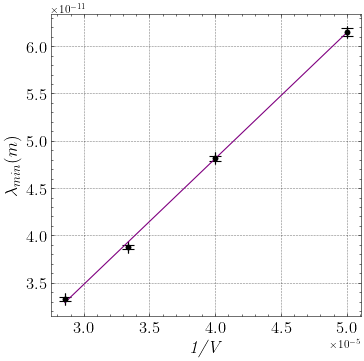

In [132]:
result = FUNCTION_FIT(V, lambda_min*1e-9, 0, delta_lambda*1e-9, 'purple', '1/V', '$\lambda_{min} (m)$', linear)

In [121]:
theor = h*c/e
print(theor)
exp = 1.330629e-06
unc = 2.799112e-08

1.2398419843320026e-06


In [122]:
# DETERMINING THE %ERROR
error = abs((exp-theor)/theor)*100
print("Percentage error: ", error, "%")
exp_precision = 100*exp/unc
print('Experimental precision:', exp_precision, '%')
print('Sigmas:', error/exp_precision)

Percentage error:  7.3224666381104395 %
Experimental precision: 4753.754047712274 %
Sigmas: 0.00154035454182455


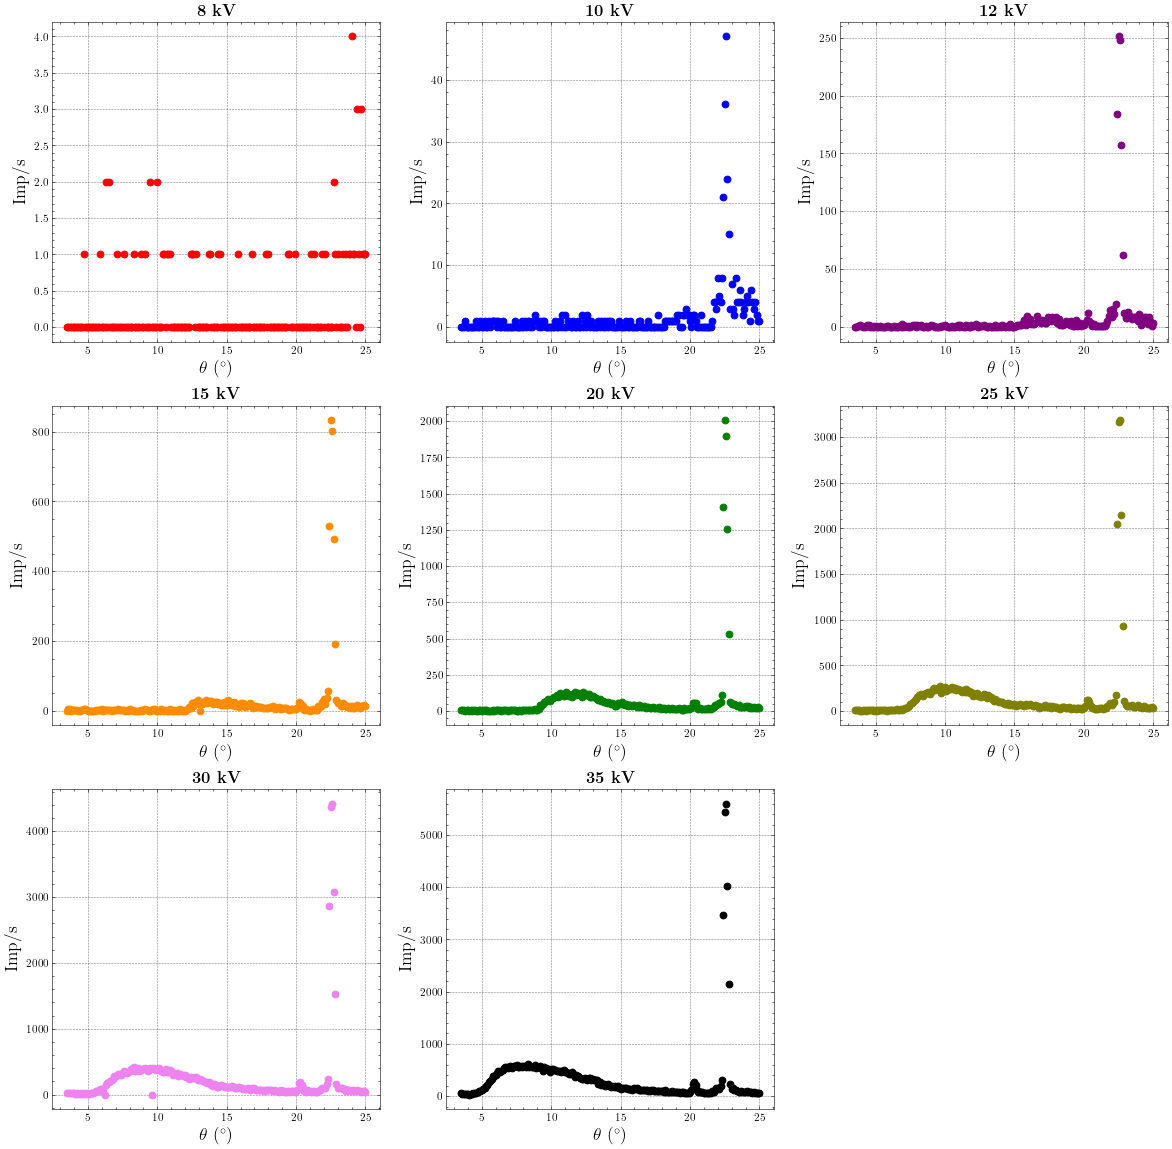

In [198]:
fig = plt.figure(figsize=(18, 18), dpi=80)
plt.subplot(3,3,1); plt.scatter(df8['Theta'], df8['Imp/s'], color='red'); plt.xlabel(r'$\theta \ (^\circ)$', fontsize = 16); plt.ylabel('Imp/s', fontsize = 16); plt.title(r"$\textbf{8 kV}$", fontsize=15)
plt.subplot(3,3,2); plt.scatter(df10['Theta'], df10['Imp/s'], color='blue'); plt.xlabel(r'$\theta \ (^\circ)$', fontsize = 16); plt.ylabel('Imp/s', fontsize = 16); plt.title(r"$\textbf{10 kV}$", fontsize=15) 
plt.subplot(3,3,3); plt.scatter(df12['Theta'], df12['Imp/s'], color='purple'); plt.xlabel(r'$\theta \ (^\circ)$', fontsize = 16); plt.ylabel('Imp/s', fontsize = 16); plt.title(r"$\textbf{12 kV}$", fontsize=15) 
plt.subplot(3,3,4); plt.scatter(df15['Theta'], df15['Imp/s'], color='darkorange'); plt.xlabel(r'$\theta \ (^\circ)$', fontsize = 16); plt.ylabel('Imp/s', fontsize = 16); plt.title(r"$\textbf{15 kV}$", fontsize=15)
plt.subplot(3,3,5); plt.scatter(df20['Theta'], df20['Imp/s'], color='green'); plt.xlabel(r'$\theta \ (^\circ)$', fontsize = 16); plt.ylabel('Imp/s', fontsize = 16); plt.title(r"$\textbf{20 kV}$", fontsize=15) 
plt.subplot(3,3,6); plt.scatter(df25['Theta'], df25['Imp/s'], color='olive'); plt.xlabel(r'$\theta \ (^\circ)$', fontsize = 16); plt.ylabel('Imp/s', fontsize = 16); plt.title(r"$\textbf{25 kV}$", fontsize=15) 
plt.subplot(3,3,7); plt.scatter(df30['Theta'], df30['Imp/s'], color='violet'); plt.xlabel(r'$\theta \ (^\circ)$', fontsize = 16); plt.ylabel('Imp/s', fontsize = 16); plt.title(r"$\textbf{30 kV}$", fontsize=15)
plt.subplot(3,3,8); plt.scatter(df35['Theta'], df35['Imp/s'], color='black'); plt.xlabel(r'$\theta \ (^\circ)$', fontsize = 16); plt.ylabel('Imp/s', fontsize = 16); plt.title(r"$\textbf{35 kV}$", fontsize=15)
plt.savefig('Figures/img.jpg')
plt.show()